In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from math import *

%matplotlib inline

# Sample Based Optimal Transport
#### (Esteban and Max's algorithm, cf Sample Based optimal transport and Barycenter Problems, 2017, Tabak, Kuang)

## Sample based Local optimal transport algorithm

## Initial data

In [2]:
#Samples
#dimension of the samples
d = 2
#generate samples
Nx = 100
Ny = 90
mu_s = np.array([0, 0])
cov_s = np.array([[1, 0], [0, 1]])
mu_t = np.array([2,2])
cov_t = np.array([[9, 0], [0, 9]])
xs = np.random.multivariate_normal(mu_s, cov_s, Nx)
xt = np.random.multivariate_normal(mu_t, cov_t, Ny)

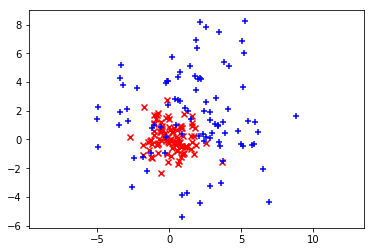

In [3]:
plt.scatter(xs[:,0],xs[:,1], c = 'r', marker = 'x');
plt.scatter(xt[:,0],xt[:,1], c = 'b', marker = '+');
plt.axis('equal')
plt.show()

Features are input manually and saved in an $M\times1$ vector $F(x) = \begin{pmatrix} F_1(x) \\ \vdots \\ F_M(x) \end{pmatrix}$, for $x \in \mathbb{R}^d$

Gradient of features are also input manually and saved in the $M \times d$ 
$$
\nabla F(x) = GF(x)= \left[ \frac{\partial F_i}{\partial x_j}(x) \right]_{\substack{i=1,..,M\\j=1,..,d}}
$$

all of these functions are defined formally, hence the use of 'lambda' in the following Python code.

In the following we add the following features: Projections on the basis $x \mapsto x_i$, $i=1,2$, this checks that the means (coordinate by coordinate) is the same, and covariances $x \mapsto x_i x_j$, $i,j=1,2$ to check that the covariances are the same.

In [4]:
#Features 
features = []
    #first append identity (projections)
for i in range(d):
    features.append(lambda x,iloc=i: x[iloc])
    #Now append covariances
for i in range(d):
    for j in range(i+1):
        features.append(lambda x,jloc=j,iloc=i: x[iloc]*x[jloc])
        
M = len(features)

#Gradient of features
gradfeatures = []
#gradient of identities
gradfeatures.append(lambda x: 1)
gradfeatures.append(lambda x: 0)
gradfeatures.append(lambda x: 0)
gradfeatures.append(lambda x: 1)
#gradient of covariances
gradfeatures.append(lambda x: 2*x[0])
gradfeatures.append(lambda x: 0)
gradfeatures.append(lambda x: x[1])
gradfeatures.append(lambda x: x[0])
gradfeatures.append(lambda x: 0)
gradfeatures.append(lambda x: 2*x[1])

#Features vector 
F = lambda x: np.array([features[i](x) for i in range(len(features))])
#Gradient of Features matrix M by d
GF = lambda x: np.array([[gradfeatures[i*d+j](x) for j in range(d)] for i in range(M)])

### Define the Implicit Gradient Descent solver for local optimal transport: 
Given two samples $(x_i)$ and $(y_j)$ 'close' enough, Theorem 8 (Tabak-Kuang, sample based optimal transport, 2017) asserts that finding a map that minimizes the transport cost is equivalent to finding a map that only satisfies the transport constraints.

So it is enough to use a non-linear solver to solve for the constraint to find the optimal map. The sample based reformulation constraint is rewritten as $G(s) - b = 0$, with:
$$
G(s) = \frac{1}{N_x} \sum_{i=1}^{N_x} F \left(x_i + s \cdot \nabla F(x_i)\right), \quad b = \frac{1}{N_y} \sum_{j=1}^{N_y} F(y_i)
$$
where we restricted our maps to be of the form $T(x) = x + s \cdot \nabla F (x)$ for $s \in \mathbb{R}^M$, and $s^* =G^{-1}(b)$ is the combination that yields the optimal map. Recall that $G:s \in \mathbb{R}^M \to \mathbb{R}^M$.

In order to solve for $G(s) - b = 0$, we will minimize the function
$$
\phi(s) = \frac{1}{2} \sum_{l=1}^M |G_l(s)-b_l|^2 
$$
by using an implicit gradient descent method, i.e. updates will be made following the implicit scheme:
$$
s_{n+1} = s_n - \delta \nabla \phi(s_{n+1})
$$
We will approximate the gradient $\nabla \phi(s_{n+1})$ by
$$
\nabla \phi(s_{n+1}) \approx \nabla \phi(s_{n}) + H\phi(s_n) (s_{n+1}-s_n)
$$
where $H\phi(s)$ is the Hessian of $\phi$ at point $s$, which is the matrix of $\left[ \partial_{i,j} \phi(s)  \right]_{i,j}$

This yields the following IGD update, after solving for $s_{n+1}$:
$$
s_{n+1} = s_n - \delta \left( I + \delta H\phi(s_n) \right)^{-1} \nabla \phi(s_{n})
$$
notice that the small $\delta$ limit yields the classical gradient descent, and the large $\delta$ limit yields Newton's method.

Finally, we compute $\nabla \phi(s_n)$ by
$$
\nabla \phi(s_n) = \sum_{l=1}^M (G_l(s_n)-b_l) \nabla G_l(s_n) = [G(s_n)-b] \cdot \nabla G(s_n)
$$
for $[\nabla G(s)]_{k,j} = \partial_j G_k(s) = \frac{1}{Nx} \sum_{i=1}^{N_x} \sum_{p=1}^d [\nabla F]_{j,p}(x_i) \; [\nabla F]_{k,p} (x_i + s \cdot \nabla F(x_i))$

and to speed up computations, we will approximate $H\phi(s)$ by dropping second order derivatives, which gives:
$$
[H\phi(s)]_{i,j} \approx \sum_{l=1}^M \partial_i G_l(s) \partial_j G_l(s)
$$


The local OT solver takes in input $(x_i)$,$(y_j)$ which are source and target cloud points in $\mathbb{R}^d$, as well as a set of feature functions $F:\mathbb{R}^d \to \mathbb{R}^M$ and the jacobian matrix of $F$, $GF:\mathbb{R}^d \to \mathbb{R}^{M \times d}$.

The output is a map $T: \mathbb{R}^d \to \mathbb{R}^d$, that maps the source sample $(x_i)$ into a sample $(z_i)$ that shares similar features with the target sample $(y_j)$.

The local OT solver will use an IGD solver that returns the optimal $s^*$ to reconstruct the map $T$.

In [5]:
def igd_solver(Phi,GPhi,HPhi,M,tol=1e-1,Maxiter = 50):
    '''Implicit Gradient Descent solver: takes as input a function Phi(s), its Jacobian matrix GPhi(s),
     its Hessian matrix HPhi(s) (all defined as functions) and the dimension of s which is M,
     and returns s* = argmin_s Phi(s)
     
     Input/type/description
     M: int, dimension of the variable we are minimizing on
     Phi: lambda (function) with input in R^M and output in R, function we are minimizing
     GPhi: lambda (function) with input in R^M and output in R^M, gradient of Phi
     HPhi: lambda (function) with input in R^M and output in R^{M \times M}, Hessian of Phi
     tol: float, max tolerance between two consecutive iteration to stop the algo
     Maxiter: int, max iterations
     
     Output/type/description
     s: M dimensional array of floats. Minimizer of Phi
     '''
    s = np.zeros(M)
    Id = np.eye(M)
    delta = 1.0
    Phiold = Phi(s)
    DescDir = np.linalg.solve(Id + delta*HPhi(s), GPhi(s)) # =(Id + delta*HPhi(s))^-1 * GPhi(s) 
    for niter in range(Maxiter):
        #compute new point
        snew = s - delta*DescDir
        Phinew = Phi(snew)
        #if tolerance reached, break
        if abs(Phinew-Phiold)<tol:
            s = snew
            break

        if Phinew < Phiold:
            s = snew #accept update of s
            delta = 2*delta #increase delta
            Phiold = Phinew #save value for comparison
            DescDir = np.linalg.solve(Id + delta*HPhi(s) ,GPhi(s)) #compute new direction
        else:
            delta = delta / 2 #decrease delta, without accepting update of s           
    return(s)

def local_sot(x,y,F,GF,tol=1e-1,Maxiter=50,solver = igd_solver):
    '''Solves the local optimal transport between two samples x and y, given a set of features
    F and their gradient GF. More details in Tabak-Kuang, Sample based OT,2017.
    This code assumes that the same features F are used to test equivalence of the samples 
    and to construct the transport maps. More precisely, maps T are sought to be of the form 
    T(x) = x + sum_{l=1}^M s_l F_l(x), for some coefficents s_l.
    A consequence of this restriction is that both samples x and y have to belong to the same
    euclidean space R^d (same dimension d), so that T : R^d -> R^d. 
    The number of samples in x and y can be different.
    
    Input/type/description
    x: Array of floats (say of dimensions Nx \times d), where Nx is the number of points and d the dimension. Source sample
    y: Array of floats (say of dimensions Ny \times d), where Ny is the number of points and d (same as x) the dimension. Target sample
    F: lambda (function) with input in R^d and output in R^M. Represents the vector of features (M features)
    GF: lambda (function) with input in R^d and output in R^{M \times d}. Represents de gradient of F, each row represents the gradient (row vector) of a feature
    tol: float. Tolerance for the non-linear solver (here we use implicit gradient descent)
    Maxiter: int. Maximum number of iterations for the nonlinear solver.
    solver: function with same inputs and outputs igd_solver. Minimization solver
    
    Output/type description
    T: lambda (function) with input in R^d and output in R^d. Optimal transport map.
    sopt: M dimensional array. Parameters to reconstruct the map (redundant with T)
    '''

    d = len(x[0])
    Nx = len(x)
    Ny = len(y)
    M = len(F(y[0]))
    b = (1/Ny) * sum([F(y[j]) for j in range(Ny)])
    #preallocate the matrix A, where A_i =\nabla F(x_i)
    A = [GF(x[i]) for i in range(Nx)]
    #Construct Phi, GPhi and HPhi to feed in minimization solver
    G = lambda s: (1/Nx)*sum([F(x[i] + s.dot(A[i])) for i in range(Nx)])
    dG = lambda s,j,k: (1/Nx)*sum([ A[i][j,p]*GF(x[i] + s.dot(A[i]))[k,p] for p in range(d) for i in range(Nx)])
    GG = lambda s: np.array([[ dG(s,j,k) for j in range(M)] for k in range(M)])
    Phi = lambda s: 0.5 * (np.linalg.norm(G(s)-b))**2
    GPhi = lambda s: (G(s)-b).dot(GG(s))
    HPhiij = lambda s,i,j: sum( [dG(s,i,l)*dG(s,j,l) for l in range(M)])
    HPhi = lambda s: np.array([[HPhiij(s,i,j) for j in range(M)] for i in range(M)])
    #solve using nonlinear solver
    sopt = solver(Phi,GPhi,HPhi,M,tol,Maxiter)
    #construct optimal map T
    T = lambda x: x + sopt.dot(GF(x)) #maybe put GF as local here?
    return(T, sopt)

Testing Local OT algorithm

In [77]:
T, s = local_sot(xs,xt,F,GF,1e-2,100)

In [78]:
Txs = np.array([T(xs[i]) for i in range(len(xs))])

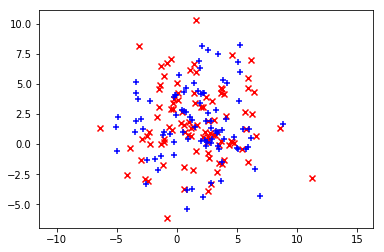

In [79]:
plt.scatter(Txs[:,0],Txs[:,1], c = 'r', marker = 'x');
plt.scatter(xt[:,0],xt[:,1], c = 'b', marker = '+');
plt.axis('equal')
plt.show()

In [80]:
print(T([1,1]))
print(T([2,2])/T([1,1]),T([4,4])/T([2,2]))

[ 4.31846952  4.82932315]
[ 1.71207665  1.7138545 ] [ 1.831828   1.8330398]


## Sample based optimal transport algorithm

In [10]:
def sot(x,y,F,GF,K=10,tol=1e-1,Maxiter=50,local_ot = local_sot):
    '''Solve the optimal transport between two samples x and y, given a set of features
    F and their gradient GF, by using a local OT code to specify. More details in Tabak-Kuang, 
    Sample based OT,2017.
    
    Input/type/description
    x: Array of floats (say of dimensions Nx \times d), where Nx is the number of points and d the dimension. Source sample
    y: Array of floats (say of dimensions Ny \times d), where Ny is the number of points and d (same as x) the dimension. Target sample
    F: lambda (function) with input in R^d and output in R^M. Represents the vector of features (M features)
    GF: lambda (function) with input in R^d and output in R^{M \times d}. Represents de gradient of F, each row represents the gradient (row vector) of a feature
    K: int, number of intermediary distribution between x and y to consider
    tol: float. Tolerance for the OT and local_ot solver
    Maxiter: int. Maximum number of iterations for OT and local_ot solver
    local_ot: solver for the local optimal transport problem, with same inputs and outputs as local_sot
    
    Output/type description
    x_K : Nx \times d array of floats. Image of the source sample to the target sample by the map
    s_maps : K \times M array of floats. s_maps[k] is the list of parameters that allows us to reconstruct the map between k and k+1. The composition of all these maps yields the final map.
    '''
    
    Nx = len(x)
    Ny = len(y)
    d = len(y[0])
    M = len(F(y[0]))
    
    s_maps = np.zeros((K,M))
    #Initialize intermediary distributions
    x_K = np.array([y[np.random.randint(0,Ny)] for i in range(Nx)])
    mu = []
    mu.append(x)
    for k in range(1,K):
        z = (1-k/K)*x+(k/K)*x_K
        mu.append(z)
    mu.append(y)
    
    for niter in range(Maxiter):
        x_Kold=x_K
        z = x
        #solve local OT's
        for k in range(1,K+1):
            Tloc, s = local_ot(z,mu[k],F,GF,tol,Maxiter)
            s_maps[k-1] = s
            z = np.array([Tloc(z[i]) for i in range(Nx)])
        x_K = z
        if (1/Nx)*np.linalg.norm(x_K-x_Kold)<tol:
            break
        #update intermediate distributions
        for k in range(1,K):
            mu[k] = (1-k/K)*x+(k/K)*x_K
            
    return(x_K, s_maps)

#### Testing SOT algorithm

In [83]:
Txs, params = sot(xs,xt,F,GF,10,1e-2,100)

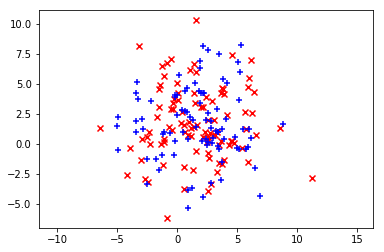

In [84]:
plt.scatter(Txs[:,0],Txs[:,1], c = 'r', marker = 'x');
plt.scatter(xt[:,0],xt[:,1], c = 'b', marker = '+');
plt.axis('equal')
plt.show()

In [90]:
def ot_map(GF,s_maps):
    '''Reconstructs optimal transport map given the basis functions and the coefficients
    of the local maps at every steps. Returns the composition of these local maps.
    
    Input/type/description
    GF: M \times d array of lambda (functions). Contains basis functions for the map
    s_maps: K \times M array of floats. Each line represents the M coefficients to reconstruct
            the local map from step k to k+1.
    
    Output/type description
    Tnew : lambda (function) with input in R^d and output in R^d. Optimal transport map
    '''
    K, M = s_maps.shape
    Tnew = lambda x: x + s_maps[0].dot(GF(x))
    for k in range(1,K):
        Told = Tnew
        Tnew = lambda x, Toldloc = Told, kloc = k: Toldloc(x) + s_maps[kloc].dot(GF(Toldloc(x)))
    return(Tnew)

#### Testing ot_map

In [92]:
T2 = ot_map(GF,params)

In [93]:
Txs2 = np.array([T2(xs[k]) for k in range(len(xs))])

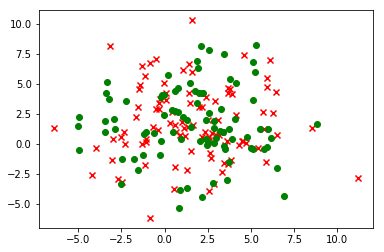

In [95]:
plt.scatter(Txs2[:,0], Txs2[:,1], c = 'r', marker = 'x')
plt.scatter(xt[:,0],xt[:,1], c = 'g', marker = 'o');